In this notebook I try to implement a simple time-series forcasting using an Artificial Neural Network. I will apply it to the daily deaths in Italy for the years 2015-2020.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from time import time
import seaborn as sns
import random
import numpy as np
import tensorflow.keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.callbacks import EarlyStopping

/Users/leonardoalchieri/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/leonardoalchieri/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/leonardoalchieri/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/leonardoalchieri/opt/anaconda3

In [3]:
START = time()

In [4]:
dat1= pd.read_csv("file:///Users/leonardoalchieri/Library/Mobile%20Documents/com~apple~CloudDocs/Unimib/1º%20anno/2º%20semestre/Data%20Science%20Lab/Progetto%20Covid/datasets/comune_giorno.csv",
                sep=',', engine='c', encoding='ISO-8859-1')

dat1 = dat1.drop(['TOTALE_15', 'TOTALE_16', 'TOTALE_17', 'TOTALE_18',
       'TOTALE_19', 'TOTALE_20'], axis=1)



dat1 = dat1.melt(var_name="SESSO_ANNO",             
               value_name="DECESSI",
              id_vars=['REG', 'PROV', 'NOME_REGIONE', 'NOME_PROVINCIA', 'NOME_COMUNE',
       'COD_PROVCOM', 'DATA_INIZIO_DIFF', 'CL_ETA', 'GE']
               )

dat1['SESSO'] = [el[0:(-3)] for el in dat1["SESSO_ANNO"]]

dat1['ANNO'] = [int(el[-2:]) for el in dat1["SESSO_ANNO"]]

dat1 = dat1.drop("SESSO_ANNO", axis=1)

bergamo_df = dat1[(dat1["DATA_INIZIO_DIFF"] == "1 aprile") & (dat1["NOME_PROVINCIA"] == "Bergamo") & (dat1["DECESSI"] < 999.)]

bergamo_df = bergamo_df.drop(["REG",'PROV','COD_PROVCOM','CL_ETA', 'DATA_INIZIO_DIFF'], axis=1)

bergamo_df = bergamo_df.query("GE != 229")

bergamo_df['DATE'] = [datetime.datetime.strptime((str(row['ANNO'])+("0")+str(row['GE'])), '%y%m%d') for index,row in bergamo_df.iterrows()]

bergamo_df = bergamo_df.drop(["GE", "NOME_REGIONE"],
                             axis=1)

bergamo_df_new = bergamo_df.groupby(['NOME_COMUNE',"DATE", "ANNO"]).sum()

In [5]:
END = time()
print("-- LOADING AND CLEANING TIME:", int(END - START), "sec")

-- LOADING AND CLEANING TIME: 31 sec


In [91]:
bergamo_df_new = bergamo_df.groupby(['NOME_COMUNE',"DATE", "ANNO"], as_index=False).sum()
bergamo_df_new = bergamo_df_new[bergamo_df_new["ANNO"] != 20]

In [92]:
bergamo_df_new

,NOME_COMUNE,DATE,ANNO,DECESSI
0,Albano Sant'Alessandro,2015-01-02,15,1
1,Albano Sant'Alessandro,2015-01-03,15,1
2,Albano Sant'Alessandro,2015-01-04,15,0
3,Albano Sant'Alessandro,2015-01-05,15,0
4,Albano Sant'Alessandro,2015-01-06,15,0
...,...,...,...,...
41452,Zanica,2019-04-22,19,0
41453,Zanica,2019-04-23,19,1
41454,Zanica,2019-04-24,19,0
41455,Zanica,2019-04-25,19,0


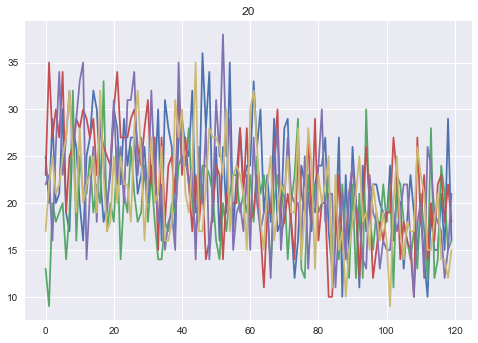

In [141]:
medie = pd.DataFrame()
for year in range(15,21):
    aux = bergamo_df_new[bergamo_df_new["ANNO"] == year].groupby(["DATE", "ANNO"], as_index=False).sum().drop("ANNO", axis=1)
    plt.plot(aux["DECESSI"])
    medie[year] = aux["DECESSI"]
#     plt.ylim([0,250])
    plt.title(year)
#     plt.show()

In [142]:
medie = medie.drop(20, axis=1)

In [144]:
medie

,15,16,17,18,19
0,25,13,23,22,17
1,20,9,35,23,22
2,29,20,27,16,25
3,20,18,30,26,21
4,21,19,27,34,22
...,...,...,...,...,...
115,15,14,22,18,21
116,21,24,23,17,14
117,15,21,18,12,14
118,29,15,22,15,12


In [194]:
avgs = pd.DataFrame({"avg":medie.sum(axis=1).rolling(window=7).mean(), "std": medie.std(axis=1).rolling(window=7).mean()})

In [195]:
avgs

,avg,std
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
115,91.428571,4.341630
116,91.428571,4.031270
117,88.428571,4.261555
118,89.285714,4.584742


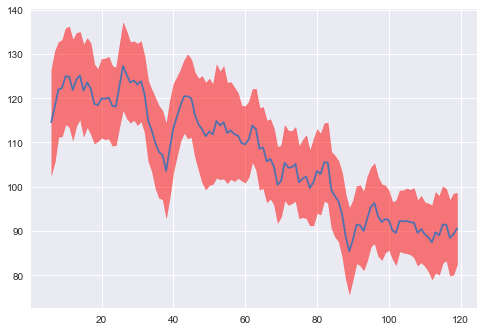

In [196]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(avgs["avg"])), avgs["avg"])
ax.fill_between(np.arange(len(avgs["avg"])), avgs["avg"] - 2*avgs["std"], avgs["avg"] + 2*avgs["std"], alpha=0.5, color='red')

In [138]:
medie["id"] = np.arange(len(medie))
medie.melt(var_name="id",             
               value_name="DECESSI",
              id_vars=['']
               )

,id,id,DECESSI
0,15,15,25
1,15,15,20
2,15,15,29
3,15,15,20
4,15,15,21
...,...,...,...
595,19,19,21
596,19,19,14
597,19,19,14
598,19,19,12


In [8]:
# aux = bergamo_df_new.groupby(["DATE"], as_index=False).sum().drop("ANNO", axis=1)

In [9]:
bergamo_df_new = bergamo_df_new[bergamo_df_new["ANNO"] == 17]
prov_bergamo = bergamo_df_new.groupby(["DATE", "ANNO"], as_index=False).sum().drop("ANNO", axis=1)
prov_bergamo_arr = np.array(prov_bergamo)

In [87]:
prov_bergamo_arr

array([[14.832288, 23],
       [14.833152, 35],
       [14.834016, 27],
       [14.83488, 30],
       [14.835744, 27],
       [14.836608, 34],
       [14.837472, 19],
       [14.838336, 25],
       [14.8392, 26],
       [14.840064, 29],
       [14.840928, 28],
       [14.841792, 30],
       [14.842656, 29],
       [14.84352, 27],
       [14.844384, 29],
       [14.845248, 23],
       [14.846112, 28],
       [14.846976, 26],
       [14.84784, 25],
       [14.848704, 24],
       [14.849568, 30],
       [14.850432, 34],
       [14.851296, 27],
       [14.85216, 27],
       [14.853024, 27],
       [14.853888, 29],
       [14.854752, 30],
       [14.855616, 26],
       [14.85648, 24],
       [14.857344, 28],
       [14.858208, 31],
       [14.859072, 22],
       [14.859936, 27],
       [14.8608, 15],
       [14.861664, 27],
       [14.862528, 18],
       [14.863392, 24],
       [14.864256, 25],
       [14.86512, 21],
       [14.865984, 32],
       [14.866848, 23],
       [14.867712, 27],
  

In [10]:
prov_bergamo_arr_1 = prov_bergamo_arr
prov_bergamo_arr_1[:,0] = [el.timestamp()/100000000. for el in prov_bergamo_arr[:,0]]
prov_bergamo_arr_1

array([[14.832288, 23],
       [14.833152, 35],
       [14.834016, 27],
       [14.83488, 30],
       [14.835744, 27],
       [14.836608, 34],
       [14.837472, 19],
       [14.838336, 25],
       [14.8392, 26],
       [14.840064, 29],
       [14.840928, 28],
       [14.841792, 30],
       [14.842656, 29],
       [14.84352, 27],
       [14.844384, 29],
       [14.845248, 23],
       [14.846112, 28],
       [14.846976, 26],
       [14.84784, 25],
       [14.848704, 24],
       [14.849568, 30],
       [14.850432, 34],
       [14.851296, 27],
       [14.85216, 27],
       [14.853024, 27],
       [14.853888, 29],
       [14.854752, 30],
       [14.855616, 26],
       [14.85648, 24],
       [14.857344, 28],
       [14.858208, 31],
       [14.859072, 22],
       [14.859936, 27],
       [14.8608, 15],
       [14.861664, 27],
       [14.862528, 18],
       [14.863392, 24],
       [14.864256, 25],
       [14.86512, 21],
       [14.865984, 32],
       [14.866848, 23],
       [14.867712, 27],
  

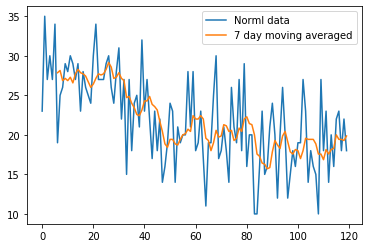

In [11]:
plt.plot(prov_bergamo.DECESSI, label='Norml data')
plt.plot(prov_bergamo.DECESSI.rolling(window=7).mean(), label="7 day moving averaged")
plt.legend()

In [12]:
aux = prov_bergamo
aux.drop('DECESSI', axis=1)
aux["DECESSI"] = prov_bergamo.DECESSI.rolling(window=7).mean()
model_data = np.array(aux)
model_data[:,0] = [el.timestamp()/100000000. for el in model_data[:,0]]
model_data[:,0] = (model_data[:,0] - 15.5)*100
model_data

array([[-66.7712, nan],
       [-66.6848, nan],
       [-66.5984, nan],
       [-66.512, nan],
       [-66.4256, nan],
       [-66.3392, nan],
       [-66.25280000000001, 27.857142857142858],
       [-66.16640000000001, 28.142857142857142],
       [-66.08000000000001, 26.857142857142858],
       [-65.99360000000001, 27.142857142857142],
       [-65.90720000000002, 26.857142857142858],
       [-65.82080000000002, 27.285714285714285],
       [-65.73440000000002, 26.571428571428573],
       [-65.64800000000002, 27.714285714285715],
       [-65.56160000000003, 28.285714285714285],
       [-65.47520000000003, 27.857142857142858],
       [-65.38880000000003, 27.714285714285715],
       [-65.30240000000003, 27.428571428571427],
       [-65.21600000000004, 26.714285714285715],
       [-65.12960000000004, 26.0],
       [-65.04320000000004, 26.428571428571427],
       [-64.95680000000004, 27.142857142857142],
       [-64.87040000000005, 27.714285714285715],
       [-64.78400000000005, 27.5714285

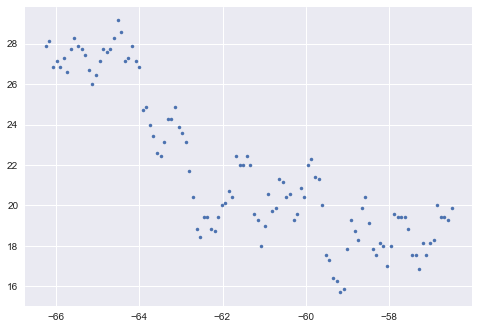

In [13]:
plt.style.use('seaborn')
plt.plot(model_data[:,0], model_data[:,1], marker='.', linestyle="")

In [14]:
model_data = np.delete(model_data, obj=range(12), axis=0)

In [71]:
model = models.Sequential()

N = 5
model.add(layers.Dense(N, input_shape=(1,), activation='elu'))
# model.add(layers.LeakyReLU(alpha=0.5))
# for _  in range(30):
model.add(layers.Dense(N, activation='linear'))
model.add(layers.Dense(N, activation='linear'))
model.add(layers.Dense(N, activation='linear'))

model.add(layers.Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 5)                 10        
_________________________________________________________________
dense_67 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_68 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_69 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_70 (Dense)             (None, 1)                 6         
Total params: 106
Trainable params: 106
Non-trainable params: 0
_________________________________________________________________


In [82]:
model.compile(optimizer='adam', metrics=['mse'], loss='mse')

In [83]:
Es = EarlyStopping(monitor='val_loss', patience=10, verbose=True)

In [84]:
history = model.fit(x = model_data[:,0],
                    y = model_data[:,1], 
                    batch_size=1,
                    epochs=50,
#                     shuffle=True,
#                     validation_data=(x_valid, y_valid),
                    verbose=True, 
                   validation_split=0.2,
                   callbacks=[Es])

Train on 86 samples, validate on 22 samples
Epoch 1/50
86/86 [==============================] - 1s 7ms/sample - loss: 9.3111 - mean_squared_error: 9.3111 - val_loss: 6.0984 - val_mean_squared_error: 6.0984
Epoch 2/50
86/86 [==============================] - 0s 2ms/sample - loss: 8.2532 - mean_squared_error: 8.2532 - val_loss: 13.6600 - val_mean_squared_error: 13.6600
Epoch 3/50
86/86 [==============================] - 0s 2ms/sample - loss: 9.1276 - mean_squared_error: 9.1276 - val_loss: 9.4449 - val_mean_squared_error: 9.4449
Epoch 4/50
86/86 [==============================] - 0s 1ms/sample - loss: 9.2700 - mean_squared_error: 9.2700 - val_loss: 5.6670 - val_mean_squared_error: 5.6670
Epoch 5/50
86/86 [==============================] - 0s 1ms/sample - loss: 8.8658 - mean_squared_error: 8.8658 - val_loss: 4.4720 - val_mean_squared_error: 4.4720
Epoch 6/50
86/86 [==============================] - 0s 2ms/sample - loss: 8.9789 - mean_squared_error: 8.9789 - val_loss: 7.4713 - val_mean_squa

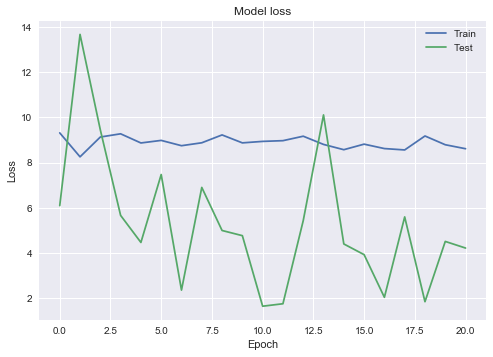

In [85]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

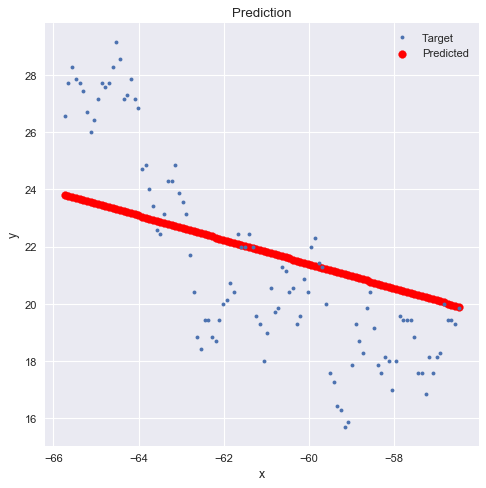

In [86]:
y_predicted = model.predict(model_data[:,0])
#
plt.figure(figsize=(7,7), dpi=80)
plt.scatter(model_data[:,0], y_predicted,color='r', label='Predicted')
plt.plot(model_data[:,0], model_data[:,1], label='Target', linestyle='', marker='.')
plt.grid(True)
plt.title('Prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.show()

In [70]:
if __name__ == "__main__":
    main()

NameError: name 'main' is not defined

-----

In [21]:
dat2 = dat1[dat1["NOME_REGIONE"] == "Lombardia"]

In [30]:
aux = 0
for name in ["1 aprile", "8 aprile", "16 aprile"]:   
    print(len(set(dat2[dat2["DATA_INIZIO_DIFF"] == name].NOME_COMUNE)))
    aux += len(set(dat2[dat2["DATA_INIZIO_DIFF"] == name].NOME_COMUNE))

434
120
68


In [39]:
dat2 = dat1[(dat1["NOME_REGIONE"] == "Lombardia") & (dat1["DECESSI"] < 999.)]
dat2 = dat2.drop(["REG",'PROV','COD_PROVCOM','CL_ETA'], axis=1)
dat2 = dat2.query("GE != 229")
dat2['DATE'] = [datetime.datetime.strptime((str(row['ANNO'])+("0")+str(row['GE'])), '%y%m%d') for index,row in dat2.iterrows()]
dat2 = dat2.drop(["GE", "NOME_REGIONE"],
                             axis=1)

In [42]:
new_cool = dat2.groupby(['NOME_COMUNE',"DATE", "ANNO", "DATA_INIZIO_DIFF"], as_index=False).sum()

In [45]:
new_cool = new_cool[new_cool["DATA_INIZIO_DIFF"] != "Dati 2020 n.d."]

In [47]:
name = "1 aprile"
aux = new_cool[new_cool["DATA_INIZIO_DIFF"] == name].groupby(["DATE", "ANNO", "DATA_INIZIO_DIFF"], as_index=False).sum().drop("ANNO", axis=1)

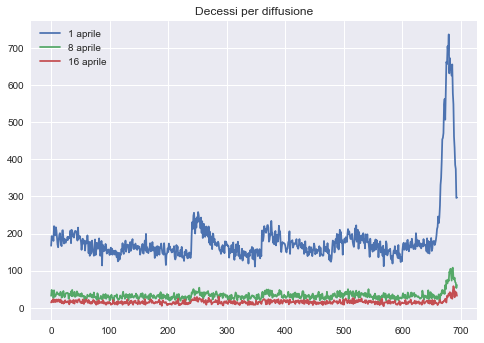

In [52]:
plt.style.use('seaborn')
for name in ["1 aprile", "8 aprile", "16 aprile"]:   
    aux = new_cool[new_cool["DATA_INIZIO_DIFF"] == name].groupby(["DATE", "ANNO", "DATA_INIZIO_DIFF"], as_index=False).sum().drop("ANNO", axis=1)
    plt.plot(aux["DECESSI"], label=name)
#     plt.ylim([0,250])
    plt.title("Decessi per diffusione")
plt.legend()
#     plt.show()